Epoch 1/500
1/4 [======>.......................] - ETA: 0s - loss: 4.8834
Epoch 1: loss improved from inf to 3.47003, saving model to best_model.h5
4/4 [==============================] - 0s 10ms/step - loss: 3.4700
Epoch 2/500
1/4 [======>.......................] - ETA: 0s - loss: 2.1056
Epoch 2: loss improved from 3.47003 to 1.75149, saving model to best_model.h5
4/4 [==============================] - 0s 8ms/step - loss: 1.7515
Epoch 3/500
1/4 [======>.......................] - ETA: 0s - loss: 1.6751
Epoch 3: loss improved from 1.75149 to 1.51307, saving model to best_model.h5
4/4 [==============================] - 0s 8ms/step - loss: 1.5131
Epoch 4/500
1/4 [======>.......................] - ETA: 0s - loss: 1.5734
Epoch 4: loss improved from 1.51307 to 1.22682, saving model to best_model.h5
4/4 [==============================] - 0s 8ms/step - loss: 1.2268
Epoch 5/500
1/4 [======>.......................] - ETA: 0s - loss: 0.9770
Epoch 5: loss improved from 1.22682 to 0.94564, saving mo

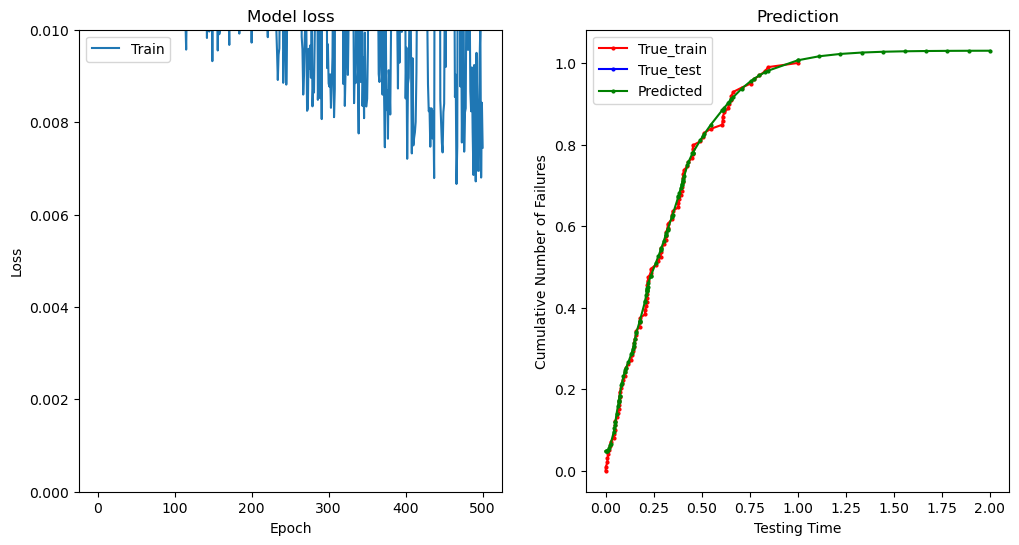

In [25]:
import numpy as np
from matplotlib import pyplot as plt
import sys

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, LSTM
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import RandomNormal, Constant
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import truncnorm

import srdata

# 1: シミュレーション
    # 1: 指数分布モデル
    # 2: ガンマ分布モデル
    # 3: 切断正規分布モデル
# 2: 実データ
    # 1: Lyu/J1.csv
    # 2: Lyu/J2.csv
    # 3: Lyu/J3.csv
    # 4: Lyu/J4.csv
    # 5: Lyu/J5.csv
data_type = 1
data_index = 3

# 学習データとテストデータの割合（全体のデータ数ににtrain_ratioをかけて小数点以下切り捨てした数が学習データ数）
train_ratio = 1

# ハイパーパラメータ
hidden_units = 500
epochs = 500
batch_size = 32

# 正規化の有無
normalization = True

# 最良モデルの保存
save_best_model = True

# 早期終了の有無（未実装）
early_stopping = False

# 早期終了のパラメータ
# patience = 10

# 学習データの重みづけの有無
sample_weight = True

# 学習のverbose
verbose = 1

# 追加の予測値
additional_prediction = True

####################################################################################################

def generate_data(data_type, dataset_index, size=100, scale=50, shape=2, loc=0):
    # シミュレーション
    if data_type == 1:
        # シードの固定
        seed = 1
        np.random.seed(seed)

        # 指数分布モデル
        if dataset_index == 1:
            # データの生成
            samples = np.random.exponential(scale, size)
            sorted_samples = np.sort(samples)

        # ガンマ分布モデル
        # 正式な分布と違う？(https://github.com/SwReliab/SRATS2017/blob/master/docs/pdfs/srats_model.pdf)
        # 将来的に逆変換サンプリングを用いて実装する予定
        elif dataset_index == 2:
            # データの生成
            samples = np.random.gamma(shape, scale, size)
            sorted_samples = np.sort(samples)

        # 切断正規分布モデル
        # 正式な分布と違う？(https://github.com/SwReliab/SRATS2017/blob/master/docs/pdfs/srats_model.pdf)
        elif dataset_index == 3:
            # データの生成
            truncnorm_dist = truncnorm((0 - loc) / scale, (np.inf - 0) / scale, loc=loc, scale=scale)
            samples = truncnorm_dist.rvs(size)
            sorted_samples = np.sort(samples)

        # データの作成
        X = sorted_samples.reshape(-1, 1)
        y = np.arange(1, len(sorted_samples) + 1).reshape(-1, 1)

    # 実データ
    elif data_type == 2:
        dataset_names = ["Lyu/J1.csv", "Lyu/J2.csv", "Lyu/J3.csv", "Lyu/J4.csv", "Lyu/J5.csv"]
        data_df = srdata.get_dataset(dataset_names[dataset_index - 1])
        data = data_df.iloc[:, 0].values
        cum_data = data.cumsum()
        X = np.arange(1, len(cum_data) + 1).reshape(-1, 1)
        y = cum_data.reshape(-1, 1)

    return X, y

####################################################################################################

# tensorflowのランダムシードの固定
tf.keras.utils.set_random_seed(1)

# データの生成
X, y = generate_data(data_type, data_index)

# データの分割
train_size = int(len(X) * train_ratio)  # 小数点以下切り捨て

# 正規化
if normalization:
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(y)

# データの分割
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# モデルの構築（Functional API）
input_layer = Input(shape=(1,))
x = Dense(hidden_units, activation="relu")(input_layer)
x = Dense(hidden_units, activation="relu")(x)
x = Dense(hidden_units, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)
output_layer = Dense(1, use_bias=False, kernel_initializer=Constant(value=1.0))(x)

model = Model(inputs=input_layer, outputs=output_layer)

# モデルのコンパイル
model.compile(loss='mse', optimizer='adam')

# モデルのサマリーをテキストファイルに保存
with open('model_summary.txt', 'w') as f:
    # 標準出力を一時的にファイルにリダイレクト
    old_stdout = sys.stdout
    sys.stdout = f

    # モデルのサマリーを出力
    model.summary()

    # 標準出力を元に戻す
    sys.stdout = old_stdout

# ModelCheckpointの設定
callbacks_list = []
if save_best_model:
    checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list.append(checkpoint)

# サンプルごとの重み
sample_weight_array = None
if sample_weight:
    sample_weight_array = np.array([i for i in range(1, len(X_train) + 1)])

# 学習
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, sample_weight=sample_weight_array, callbacks=callbacks_list)

if (save_best_model):
    model = load_model('best_model.h5')
    min_loss_index = np.argmin(history.history['loss'])
    print("Best model is from epoch {} and loss is {}".format(min_loss_index + 1, history.history['loss'][min_loss_index]))

# パラメータを保存
# h5形式で保存
model.save_weights('weights/weights.h5')
# テキスト形式で保存
weights = model.get_weights()
with open('weights/model_weights.txt', 'w') as f:
    for layer_weights in weights:
        np.savetxt(f, layer_weights, fmt='%s')

# 損失関数をプロット（横軸：エポック，縦軸：損失関数）
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
if MinMaxScaler:
    plt.ylim(0, 0.01)   # 正規化する場合ylimを制限しないと損失関数が小さくなりすぎて見えなくなる
plt.legend(['Train'], loc='upper left')

# 予測（学習データも含む）
pred_X = X
if additional_prediction and normalization:
    pred_X = np.append(pred_X, np.linspace(1, 2, 10).reshape(-1, 1))
predictions = model.predict(pred_X)

# 推定フォールト数の表示
if normalization:
    print("Predicted number of faults: {}".format(scaler_X.inverse_transform(predictions)[-1]))
else :
    print("Predicted number of faults: {}".format(predictions[-1]))

# 予測値のプロット
plt.subplot(1, 2, 2)
plt.plot(X_train, y_train, color="red", label='True_train', marker='o', markersize=2)
plt.plot(X_test, y_test, color="blue", label='True_test', marker='o', markersize=2)
plt.plot(pred_X, predictions, color="green", label='Predicted', marker='o', markersize=2)
plt.title('Prediction')
plt.xlabel('Testing Time')
plt.ylabel('Cumulative Number of Failures')
plt.legend()
plt.show()